<a href="https://colab.research.google.com/github/AdnanBayu/LSTM-Flex-Sensor/blob/main/Torch_LSTM_Flex_Sensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT

In [ ]:
# @title <p>Essential Import
import os, shutil, json
from zipfile import ZipFile
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, random as rd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report
import warnings
import gdown
import torch
import torch.nn.functional as Functional
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# @title <p> Download Data Sensor Real
url = 'https://drive.google.com/file/d/1SOUWbn0SSH-nQ4AgVghXAeEerPniHhdM/view?usp=sharing'
output_path = 'data-real.zip'
gdown.download(url, output_path, quiet=False,fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1SOUWbn0SSH-nQ4AgVghXAeEerPniHhdM
To: /content/data-real.zip
100%|██████████| 2.32M/2.32M [00:00<00:00, 88.6MB/s]


'data-real.zip'

In [ ]:
# @title <p> Download Data Real Config Real
url = 'https://drive.google.com/file/d/1zFfUlMn9aCm9Ngvj3ENKBo3KaK6apNSB/view?usp=sharing'
output_path = 'data-real-config.zip'
gdown.download(url, output_path, quiet=False,fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1zFfUlMn9aCm9Ngvj3ENKBo3KaK6apNSB
To: /content/data-real-config.zip
100%|██████████| 3.50k/3.50k [00:00<00:00, 9.78MB/s]


'data-real-config.zip'

In [ ]:
# @title <p> Assign file path
DATA_DIR = 'data'
CONFIG_DIR = 'data-real-config/config'

if not os.path.isdir(DATA_DIR) :
  !unzip data-real.zip &> /dev/null

if not os.path.isdir(CONFIG_DIR) :
  !unzip data-real-config.zip &> /dev/null

In [ ]:
# @title <p> Formatting Data Real
columns = [f'finger{n}' for n in range(1, 6)] + ['acc_x', 'acc_y', 'acc_z', 'gir_x', 'gir_y', 'gir_z', 'label', 'name', 'file']
data_arr = []
# include = ['ade', 'alfa', 'amalia', 'anes', 'bayu', 'cahyan', 'nurhadi', 'timo', 'zalfa', 'additional'] #exclude anis
include = ['amalia', 'bayu', 'nurhadi', 'timo', 'additional']

def convert_data_str_int(data):
    return [float(x) for x in data.split(',')]

#read each file by alphabet name
for name in os.listdir(DATA_DIR):
  for letter in os.listdir(os.path.join(DATA_DIR,name)):
    for data_point in os.listdir(os.path.join(DATA_DIR,name,letter)):
      if name in include:
        data_path = os.path.join(DATA_DIR, name, letter, data_point)
        with open(data_path, 'r') as f:
          lines = f.readlines()
          lines = lines[-30:]
        for line in lines:
          data_arr.append(convert_data_str_int(line) + [letter] + [name] + [data_point])

In [ ]:
# @title <p> Create Dataframe
data_df = pd.DataFrame(data_arr, columns = columns)
data_df = data_df.drop(['acc_x', 'acc_y', 'acc_z', 'gir_x', 'gir_y', 'gir_z'], axis=1)
data_df = data_df.sort_index()
data_df = data_df.sort_values(by='label', kind='stable')
data_df.head()

,finger1,finger2,finger3,finger4,finger5,label,name,file
9293,3431.0,3818.0,3920.0,3517.0,3612.0,a,additional,a-13.txt
9294,3430.0,3823.0,3920.0,3518.0,3607.0,a,additional,a-13.txt
9295,3434.0,3818.0,3927.0,3517.0,3605.0,a,additional,a-13.txt
9296,3423.0,3810.0,3917.0,3518.0,3611.0,a,additional,a-13.txt
9297,3429.0,3815.0,3915.0,3519.0,3606.0,a,additional,a-13.txt


#DATA VISUALIZATION

In [ ]:
# @title <p> Create Variable for Sensor Visualization Check
PARTICIPANT_NAME = "timo" #@param{type: 'string'}
LETTER_PRINT = "p" #@param{type: 'string'}
FILE_PRINT = [f'{LETTER_PRINT}-{n}.txt' for n in range(1,6)]

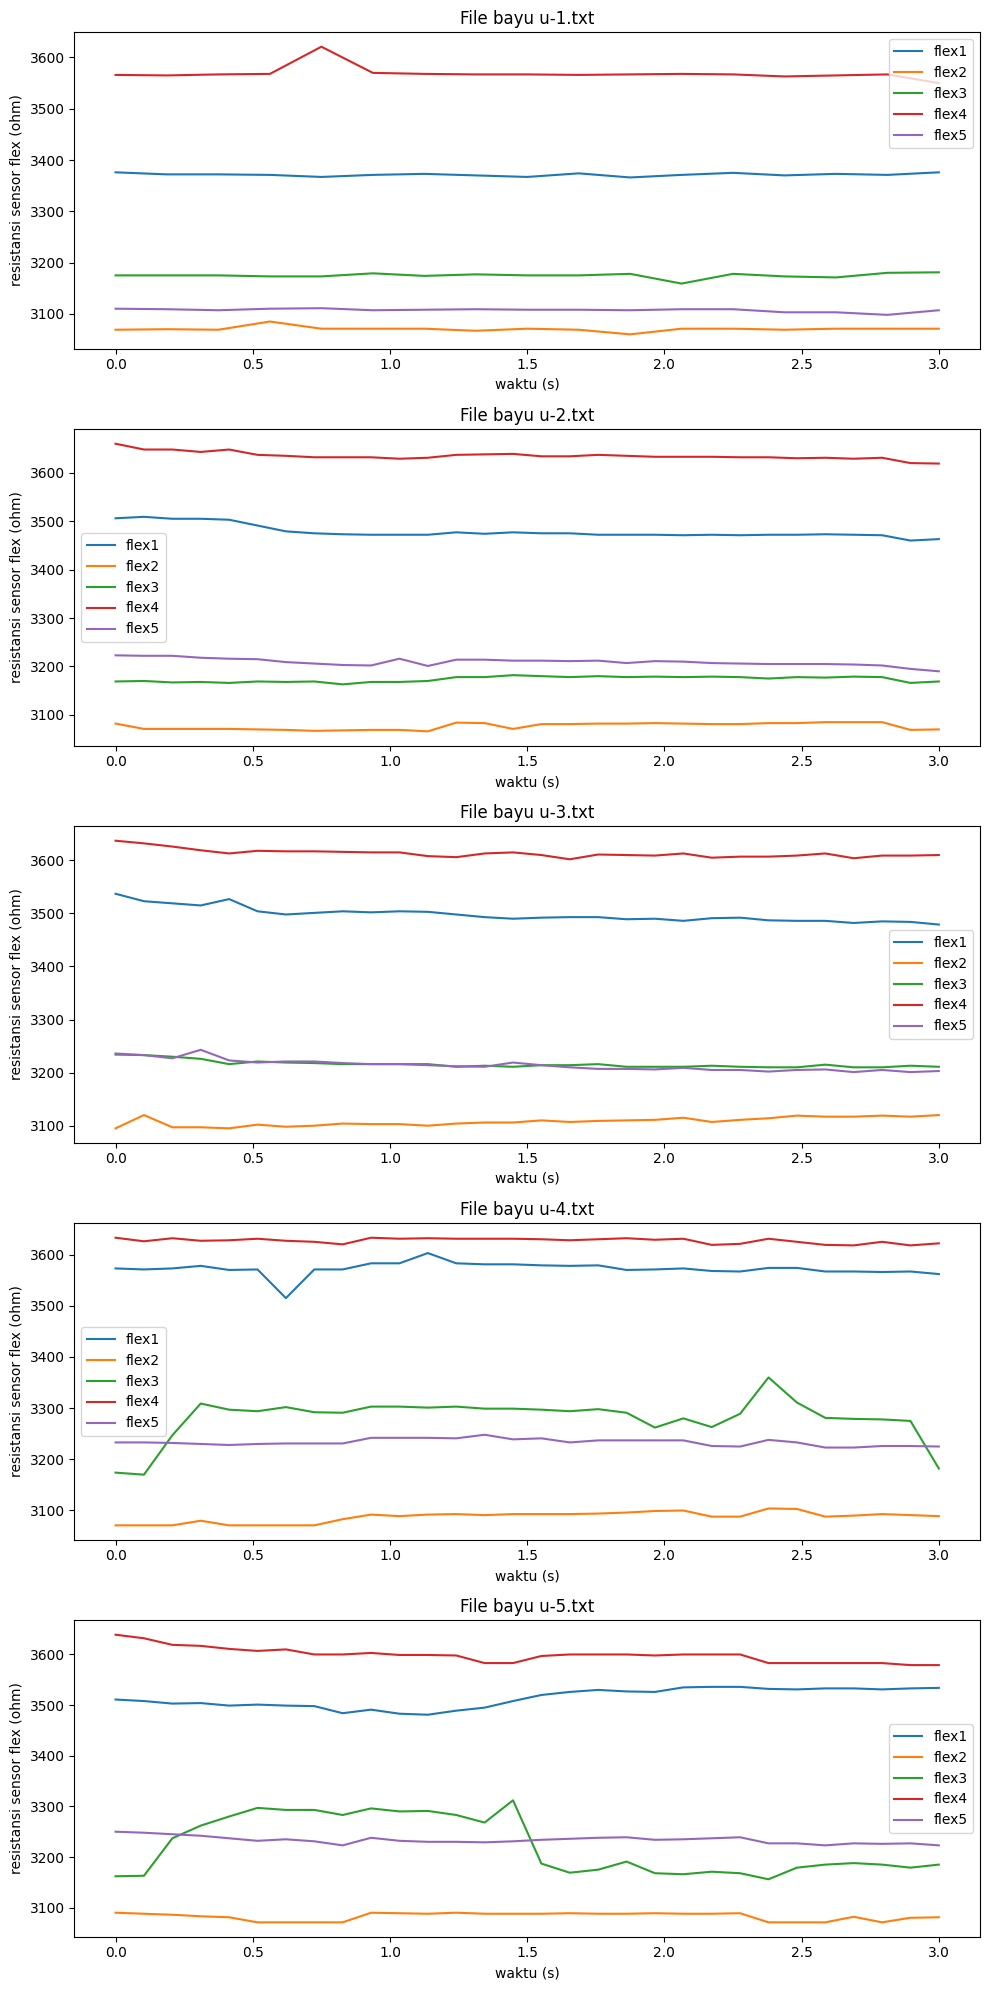

In [ ]:
# @title <p> Check Flex Sensor Data
def sensor_viz_flex(data, name, letter, file_print):
  data_viz = data[data['name'] == name]
  data_viz = data_viz[data_viz['label'] == letter]

  # Create subplots
  fig, axes = plt.subplots(5, 1, figsize=(10, 20))
  axes = axes.flatten()  # Flatten the 2x2 array of axes for easy iteration

  # Loop through the data and axes to create subplots
  for i, ax in enumerate(axes):
    if i < len(file_print):
        file = file_print[i]
        data_to_plot = data_viz[data_viz["file"] == file]
        # print(data_to_plot.iloc[:,0:5])

        time = np.linspace(0, 3, data_to_plot.shape[0])

        for j in range(5):
          ax.plot(time, data_to_plot.iloc[:,j], label=f'flex{j+1}')

        ax.set_title(f'File {name} {file}')
        ax.set_xlabel('waktu (s)')
        ax.set_ylabel('resistansi sensor flex (ohm)')
        ax.legend()
    else:
        ax.axis('off')  # Turn off empty subplots

  plt.tight_layout()
  plt.show()

sensor_viz_flex(data_df, PARTICIPANT_NAME, LETTER_PRINT, FILE_PRINT)

# DATA CONFIG IMPORT

In [ ]:
# @title <p> Check txt File Contents
f = open(os.path.join(CONFIG_DIR, 'ade.txt'), 'r')
contents = f.read()
print(contents)

max of 1'st finger : 2718.0, 
min of 1'st finger : 2555.0, 
max of 2'st finger : 2735.0, 
min of 2'st finger : 2608.0, 
max of 3'st finger : 3711.0, 
min of 3'st finger : 3278.0, 
max of 4'st finger : 3275.0, 
min of 4'st finger : 3148.0, 
max of 5'st finger : 3066.0, 
min of 5'st finger : 2797.0, 



In [ ]:
# @title <p> Formatting Config Data
minmax_fingers = ['max_1',
           'min_1',
           'max_2',
           'min_2',
           'max_3',
           'min_3',
           'max_4',
           'min_4',
           'max_5',
           'min_5']
config_participants = [a for a in os.listdir(CONFIG_DIR)]
config_dict = {participant : {config_fingers : [] for config_fingers in minmax_fingers} for participant in config_participants}
config_dict_cleaned = {participant : {config_fingers : [] for config_fingers in minmax_fingers} for participant in config_participants}

#read each file by participant name
for name in os.listdir(CONFIG_DIR):
  data_path = os.path.join(CONFIG_DIR, name)
  with open(data_path, 'r') as f:
    content = f.read().splitlines()
    for i, finger in enumerate(minmax_fingers):
      data_line = float(content[i].split(':')[-1][:-2].strip())
      config_dict_cleaned[name][finger].append(data_line)

In [ ]:
# @title <p> Check Formatted Config Data
config_dict_cleaned['ade.txt']

{'max_1': [2718.0],
 'min_1': [2555.0],
 'max_2': [2735.0],
 'min_2': [2608.0],
 'max_3': [3711.0],
 'min_3': [3278.0],
 'max_4': [3275.0],
 'min_4': [3148.0],
 'max_5': [3066.0],
 'min_5': [2797.0]}

In [ ]:
config_dict_cleaned['additional.txt'] = {
    'max_1': [4100.0],
    'min_1': [2500.0],
    'max_2': [4100.0],
    'min_2': [2500.0],
    'max_3': [4100.0],
    'min_3': [2500.0],
    'max_4': [4100.0],
    'min_4': [2500.0],
    'max_5': [4100.0],
    'min_5': [2500.0]
}

In [ ]:
# @title <p> Add Config Min-Max to DataFrame
for nc in minmax_fingers:
  data_df[nc] = data_df["name"].apply(lambda x: config_dict_cleaned[f"{x}.txt"][nc][0])

data_df

,finger1,finger2,finger3,finger4,finger5,label,name,file,max_1,min_1,max_2,min_2,max_3,min_3,max_4,min_4,max_5,min_5
1021,3151.0,3785.0,4049.0,3808.0,3383.0,a,bayu,a-5.txt,3664.0,3043.0,3718.0,3059.0,3805.0,3371.0,3730.0,3063.0,3113.0,2795.0
1022,3150.0,3786.0,4016.0,3803.0,3379.0,a,bayu,a-5.txt,3664.0,3043.0,3718.0,3059.0,3805.0,3371.0,3730.0,3063.0,3113.0,2795.0
1023,3145.0,3783.0,3974.0,3804.0,3379.0,a,bayu,a-5.txt,3664.0,3043.0,3718.0,3059.0,3805.0,3371.0,3730.0,3063.0,3113.0,2795.0
1024,3143.0,3781.0,3856.0,3805.0,3378.0,a,bayu,a-5.txt,3664.0,3043.0,3718.0,3059.0,3805.0,3371.0,3730.0,3063.0,3113.0,2795.0
1025,3147.0,3776.0,3856.0,3804.0,3376.0,a,bayu,a-5.txt,3664.0,3043.0,3718.0,3059.0,3805.0,3371.0,3730.0,3063.0,3113.0,2795.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20893,3583.0,3189.0,3862.0,3463.0,3388.0,z,additional,z-4.txt,4100.0,2500.0,4100.0,2500.0,4100.0,2500.0,4100.0,2500.0,4100.0,2500.0
20894,3601.0,3201.0,3869.0,3473.0,3405.0,z,additional,z-4.txt,4100.0,2500.0,4100.0,2500.0,4100.0,2500.0,4100.0,2500.0,4100.0,2500.0
20895,3583.0,3200.0,3866.0,3475.0,3417.0,z,additional,z-4.txt,4100.0,2500.0,4100.0,2500.0,4100.0,2500.0,4100.0,2500.0,4100.0,2500.0
20896,3573.0,3196.0,3866.0,3472.0,3428.0,z,additional,z-4.txt,4100.0,2500.0,4100.0,2500.0,4100.0,2500.0,4100.0,2500.0,4100.0,2500.0


# DATASET PREPROCESSING

## 1) Data Distribution

In [ ]:
# @title <p> Check Total Data for Each Label
label_counts = data_df['label'].value_counts().sort_index()
print(label_counts)

label
a    1200
b    1200
c    1200
d    1200
e    1230
f    1200
g    1200
h    1200
i    1200
j    1200
k    1200
l    1193
m    1200
n    1200
o    1200
p    1200
q    1200
r    1200
s    1170
t    1170
u    1157
v    1170
w    1170
x    1170
y    1170
z     991
Name: count, dtype: int64


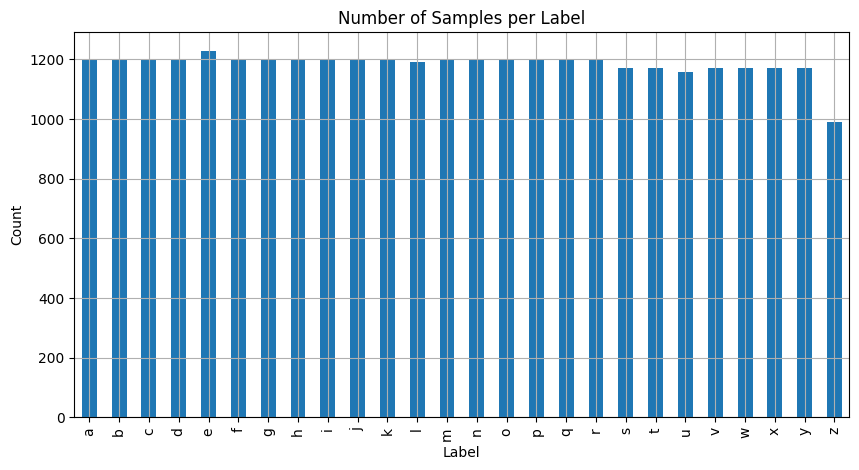

In [ ]:
# @title <p> Visualize Total Data for Each Label
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar')
plt.title('Number of Samples per Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [ ]:
# @title <p> Check If There's Any Data Less Than Determined Length Row
pairs_to_drop = data_df.groupby(['name', 'file']).size()
drop_count = pairs_to_drop[pairs_to_drop < 20].sort_values()
print(drop_count)

name  file   
bayu  z-5.txt     1
      u-1.txt    17
dtype: int64


In [ ]:
# @title <p> Remove Data That Has Less Than Determined Length Row
index_to_drop = pairs_to_drop[pairs_to_drop < 20].index
filtered_df = data_df[~data_df.set_index(['name', 'file']).index.isin(index_to_drop)]

In [ ]:
# @title <p> Filter the Unused Label and Make All Label Have Same Amount of Data
filtered_df = filtered_df[filtered_df['label'] != 'B']
# filtered_df = data_df.groupby('label', group_keys=False).head(1050)

In [ ]:
# @title <p> Check Total Data of Each Label After Filtered
label_counts = filtered_df['label'].value_counts().sort_index()
print(label_counts)

label
a    1200
b    1200
c    1200
d    1200
e    1230
f    1200
g    1200
h    1200
i    1200
j    1200
k    1200
l    1193
m    1200
n    1200
o    1200
p    1200
q    1200
r    1200
s    1170
t    1170
u    1140
v    1170
w    1170
x    1170
y    1170
z     990
Name: count, dtype: int64


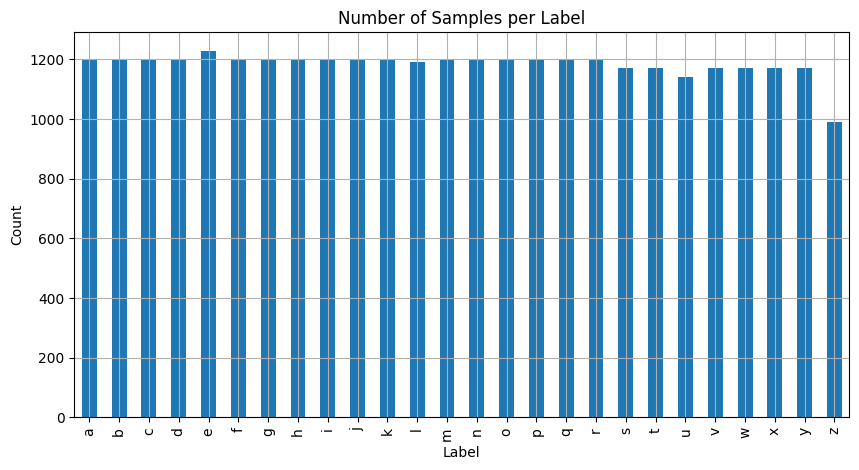

In [ ]:
# @title <p> Visualize Total Data for Each Label After Filtered
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar')
plt.title('Number of Samples per Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(True)
plt.show()

## 2) Data Normalization

In [ ]:
# @title <p> check data minimum and maximum value of each finger (not from config)
for col in columns[0:5]:
  min_val_act = filtered_df[col].min()
  max_val_act = filtered_df[col].max()
  print(f"--------------------------------------")
  print(f"min value of column {col}", min_val_act)
  print(f"max value of column {col}", max_val_act)
  print(f"--------------------------------------")

--------------------------------------
min value of column finger1 154.0
max value of column finger1 4034.0
--------------------------------------
--------------------------------------
min value of column finger2 2807.0
max value of column finger2 4030.0
--------------------------------------
--------------------------------------
min value of column finger3 3055.0
max value of column finger3 4095.0
--------------------------------------
--------------------------------------
min value of column finger4 2945.0
max value of column finger4 4022.0
--------------------------------------
--------------------------------------
min value of column finger5 2734.0
max value of column finger5 3643.0
--------------------------------------


In [ ]:
# @title <p> check data minimum and maximum value of each finger (not from config)
for name_peserta in filtered_df["name"].unique():
  df_peserta_temp = filtered_df[filtered_df["name"] == name_peserta]
  print("-"*50)
  print(f"\nMin Max Value {name_peserta}")
  for col in columns[0:5]:
    min_val_act = df_peserta_temp[col].min()
    max_val_act = df_peserta_temp[col].max()
    print(f"\nmin value {col}", min_val_act, "\tmax value {col}", max_val_act)
  print("-"*50)

--------------------------------------------------

Min Max Value bayu

min value finger1 2955.0 	max value {col} 3766.0

min value finger2 3024.0 	max value {col} 3817.0

min value finger3 3115.0 	max value {col} 4095.0

min value finger4 3024.0 	max value {col} 3863.0

min value finger5 2746.0 	max value {col} 3409.0
--------------------------------------------------
--------------------------------------------------

Min Max Value amalia

min value finger1 2971.0 	max value {col} 3706.0

min value finger2 2807.0 	max value {col} 3856.0

min value finger3 3135.0 	max value {col} 3886.0

min value finger4 2945.0 	max value {col} 3856.0

min value finger5 2752.0 	max value {col} 3424.0
--------------------------------------------------
--------------------------------------------------

Min Max Value nurhadi

min value finger1 154.0 	max value {col} 3733.0

min value finger2 2938.0 	max value {col} 3862.0

min value finger3 3055.0 	max value {col} 3984.0

min value finger4 2986.0 	max 

In [ ]:
#  @title <p> Drop the weird value
for col in columns[0:5]:
  weird_value = filtered_df[filtered_df[col] <= 2500]
  filtered_df.drop(weird_value.index, inplace = True)

In [ ]:
# @title <p> Recheck data minimum and maximum value of each finger after drop weird value
for col in columns[0:5]:
  min_val_act = filtered_df[col].min()
  max_val_act = filtered_df[col].max()
  print(f"--------------------------------------")
  print(f"min value of column {col}", min_val_act)
  print(f"max value of column {col}", max_val_act)
  print(f"--------------------------------------")

--------------------------------------
min value of column finger1 2911.0
max value of column finger1 4034.0
--------------------------------------
--------------------------------------
min value of column finger2 2807.0
max value of column finger2 4030.0
--------------------------------------
--------------------------------------
min value of column finger3 3055.0
max value of column finger3 4095.0
--------------------------------------
--------------------------------------
min value of column finger4 2945.0
max value of column finger4 4022.0
--------------------------------------
--------------------------------------
min value of column finger5 2734.0
max value of column finger5 3643.0
--------------------------------------


In [ ]:
# @title <p> Flex data normalization
def do_normalize_minmax(value, fingern):
  config_max = value[f'max_{fingern[-1:]}']
  config_min = value[f'min_{fingern[-1:]}']
  flex_normalized = (value[fingern] - config_min)/(config_max - config_min)
  return round(flex_normalized, 3)

def do_normalize_flex(value, fingern):
  flex_normalized = (value[fingern] - 2500)/(4100 - 2500)   #using min 2500 and max 4100
  return round(flex_normalized, 3)

def norm_loc(x):
  global columns
  for i in columns[0:5]:
    x[i] = do_normalize_flex(x, i)

  return x

df_normalized = filtered_df.apply(lambda x: norm_loc(x), axis=1)

df_normalized.head()

,finger1,finger2,finger3,finger4,finger5,label,name,file,max_1,min_1,max_2,min_2,max_3,min_3,max_4,min_4,max_5,min_5
1021,0.407,0.803,0.968,0.818,0.552,a,bayu,a-5.txt,3664.0,3043.0,3718.0,3059.0,3805.0,3371.0,3730.0,3063.0,3113.0,2795.0
1022,0.406,0.804,0.948,0.814,0.549,a,bayu,a-5.txt,3664.0,3043.0,3718.0,3059.0,3805.0,3371.0,3730.0,3063.0,3113.0,2795.0
1023,0.403,0.802,0.921,0.815,0.549,a,bayu,a-5.txt,3664.0,3043.0,3718.0,3059.0,3805.0,3371.0,3730.0,3063.0,3113.0,2795.0
1024,0.402,0.801,0.848,0.816,0.549,a,bayu,a-5.txt,3664.0,3043.0,3718.0,3059.0,3805.0,3371.0,3730.0,3063.0,3113.0,2795.0
1025,0.404,0.797,0.848,0.815,0.547,a,bayu,a-5.txt,3664.0,3043.0,3718.0,3059.0,3805.0,3371.0,3730.0,3063.0,3113.0,2795.0


In [ ]:
#  @title <p> Check if there's any value below 0
for col in columns[0:5]:
  respondent_error = df_normalized[df_normalized[col] < 0]

respondent_error

,finger1,finger2,finger3,finger4,finger5,label,name,file,max_1,min_1,max_2,min_2,max_3,min_3,max_4,min_4,max_5,min_5


In [ ]:
#  @title <p> Recheck data minimum and maximum value of each finger (not from config) after normalized
for col in columns[0:5]:
  min_val_act = df_normalized[col].min()
  max_val_act = df_normalized[col].max()
  print(f"--------------------------------------")
  print(f"min value of column {col}", min_val_act)
  print(f"max value of column {col}", max_val_act)
  print(f"--------------------------------------")

--------------------------------------
min value of column finger1 0.257
max value of column finger1 0.959
--------------------------------------
--------------------------------------
min value of column finger2 0.192
max value of column finger2 0.956
--------------------------------------
--------------------------------------
min value of column finger3 0.347
max value of column finger3 0.997
--------------------------------------
--------------------------------------
min value of column finger4 0.278
max value of column finger4 0.951
--------------------------------------
--------------------------------------
min value of column finger5 0.146
max value of column finger5 0.714
--------------------------------------


In [ ]:
# @title <p> Check Total Data of Each Label After Filtered
label_counts = df_normalized['label'].value_counts().sort_index()
print(label_counts)

label
a    1200
b    1200
c    1200
d    1200
e    1230
f    1200
g    1200
h    1200
i    1200
j    1200
k    1200
l    1193
m    1200
n    1200
o    1200
p    1199
q    1200
r    1200
s    1170
t    1170
u    1140
v    1170
w    1170
x    1170
y    1170
z     990
Name: count, dtype: int64


# SPLIT DATA

## 1) Split Function

In [ ]:
# @title <p> Drop the unwanted columns
df_ready = df_normalized.drop(columns=["name", "file", "max_1", "min_1", "max_2", "min_2", "max_3", "min_3", "max_4", "min_4", "max_5", "min_5"], axis=-1)
df_ready

,finger1,finger2,finger3,finger4,finger5,label
1021,0.407,0.803,0.968,0.818,0.552,a
1022,0.406,0.804,0.948,0.814,0.549,a
1023,0.403,0.802,0.921,0.815,0.549,a
1024,0.402,0.801,0.848,0.816,0.549,a
1025,0.404,0.797,0.848,0.815,0.547,a
...,...,...,...,...,...,...
20893,0.677,0.431,0.851,0.602,0.555,z
20894,0.688,0.438,0.856,0.608,0.566,z
20895,0.677,0.438,0.854,0.609,0.573,z
20896,0.671,0.435,0.854,0.608,0.580,z


In [ ]:
# @title <p> Reshape the data as sequences
def create_sequences(df_ready, seq_length=20, stride=2):
  data_dict = {}
  letters = df_ready['label'].unique()

  for letter in letters:
        letter_df = df_ready[df_ready['label'] == letter].drop('label', axis=1)
        arr = letter_df.to_numpy().astype(np.float32)

        sequences = []
        for i in range(0, len(arr) - seq_length + 1, stride):
            window = arr[i:i + seq_length]  # shape: (20, 5)
            tensor = torch.tensor(window)
            sequences.append(tensor)

        if sequences:
            data_dict[letter] = sequences
        else:
            print(f"No valid sequences for letter {letter}, skipping.")

  return data_dict

In [ ]:
# @title <p> Split the data to train, test, val
def split_data(dict, val_test_size=0.3):
  trainset, testset, valset = {}, {}, {}

  for letter, data in sequenced_dict.items():
    traindata, tempdata = train_test_split(data, test_size=val_test_size, random_state=42, shuffle=True)
    valdata, testdata = train_test_split(tempdata, test_size=0.5, random_state=42, shuffle=True)

    if letter in trainset:
      trainset[letter].append(traindata)
      valset[letter].append(valdata)
      testset[letter].append(testdata)
    else:
      trainset[letter] = np.array(traindata)
      valset[letter] = np.array(valdata)
      testset[letter] = np.array(testdata)

  return trainset, valset, testset

In [ ]:
# @title <p> One hot encode labels and create sequence
class SIBIDataset(Dataset):
    def __init__(self, data_dict):
      self.data_dict = data_dict
      self.features = []
      self.labels = []

      for letter, data in data_dict.items():
        for feature in data:
          self.features.append(feature)
          self.labels.append(Functional.one_hot(torch.tensor(ord(letter) - 97), num_classes=26).float())

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [ ]:
# @title <p> Create data loader
BATCH_SIZE = 32
NUM_WORKERS = 1
SEQ_LENGTH = 20

sequenced_dict = create_sequences(df_ready)
trainset, valset, testset = split_data(sequenced_dict)

trainseq = SIBIDataset(trainset)
valseq = SIBIDataset(valset)
testseq = SIBIDataset(testset)

trainloader = DataLoader(trainseq, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valloader = DataLoader(valseq, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = DataLoader(testseq, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

## 2) Check Data

In [ ]:
for letter, data in sequenced_dict.items():
  print(letter)
  print(len(data))
  break

a
591


In [ ]:
len(trainset['a'])

413

In [ ]:
len(testset['a'])

89

In [ ]:
len(trainset), len(valset), len(testset)

(26, 26, 26)

In [ ]:
len(trainseq), len(valseq), len(testseq)

(10592, 2275, 2284)

In [ ]:
trainseq[0][0].shape, trainseq[0][1].shape

((20, 5), torch.Size([26]))

In [ ]:
# for batch, (X, y) in enumerate(trainloader):
#     print(f"Batch: {batch+1}")
#     print(f"X shape: {X.shape}")
#     print(f"y shape: {y.shape}")
#     print(f"X: {X}")
#     print(f"y: {y}")
#     break

# TRAINING DATA

In [ ]:
# @title <p> Initialize LSTM model
class SIBILSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size, seq_length=20):
    super(SIBILSTMModel, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.3, batch_first=True, bidirectional=True)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=seq_length*hidden_size*2, out_features=hidden_size)
    self.ln = nn.LayerNorm(hidden_size)
    self.dropout = nn.Dropout(p=0.3)
    self.fc2 = nn.Linear(in_features=hidden_size, out_features=output_size)


  def forward(self, x):
    num_directions = 2
    h0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers * num_directions, x.size(0), self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out_flat = self.flatten(out)

    out_fc1 = Functional.relu(self.ln(self.fc1(out_flat)))
    out_fc2 = self.fc2(self.dropout(out_fc1))
    pred = out_fc2

    return pred

In [ ]:
# # @title <p> Initialize LSTM model
# class SIBILSTMModel(nn.Module):
#   def __init__(self, input_size, hidden_size, num_layers, output_size):
#     super(SIBILSTMModel, self).__init__()

#     self.hidden_size = hidden_size
#     self.num_layers = num_layers
#     self.num_directions = 2

#     self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.3, batch_first=True, bidirectional=True)
#     self.dropout = nn.Dropout(p=0.3)
#     self.layer_norm = nn.LayerNorm(hidden_size * self.num_directions)
#     self.fc1 = nn.Linear(in_features=hidden_size * self.num_directions, out_features=hidden_size * 2)
#     self.fc2 = nn.Linear(in_features=hidden_size * 2, out_features=output_size)


#   def forward(self, x):
#     batch_size = x.size(0)
#     h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(device)
#     c0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(device)

#     out, _ = self.lstm(x, (h0, c0)) # out shape: (batch, seq_len, hidden * 2)
#     out_last = out[:, -1, :]

#     out_fc1 = Functional.relu(self.layer_norm(self.fc1(out_last)))
#     out_fc2 = self.fc2(self.dropout(out_fc1))
#     pred = out_fc2

#     return pred

In [ ]:
# @title <p> Create Model Training Loop Function
def train_loop(train_loader, val_loader, epoch_num, patience, model, loss_fn, optimizer, device, scheduler=None):
  train_loss_values, validation_loss_values = list(), list()
  train_accuracy_values, validation_accuracy_values = list(), list()
  model = model.to(device)
  best_val_acc = -1

  for epoch in range(epoch_num):
    # print epoch count
    print("-" * 40)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()

    train_loss, step = 0, 1
    steps_per_epoch = len(trainset) // train_loader.batch_size

    tload = tqdm(train_loader)
    tload.set_description(f"Epoch: {epoch+1}")

    total_train_preds, total_train_labels = list(), list()

    # Train
    for batch_data in tload:
      train_data, train_labels = batch_data[0].to(device), batch_data[1].to(device)
      optimizer.zero_grad()

      train_pred = model(train_data)

      total_train_preds.append(train_pred)
      total_train_labels.append(train_labels)

      loss = loss_fn(train_pred, train_labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

      tload.set_postfix(loss=loss.item())
      step += 1

    train_loss /= len(train_loader)
    train_loss_values.append(train_loss)

    y_train_pred = torch.cat(total_train_preds)
    y_train_labels = torch.cat(total_train_labels)

    train_true_pred = [torch.argmax(x1) == torch.argmax(x2) for x1, x2 in zip(y_train_pred, y_train_labels)]
    train_acc = float(sum(1 for i in train_true_pred if i))/len(y_train_pred)
    train_accuracy_values.append(train_acc)

    if scheduler is not None:
      scheduler.step(train_loss)
      for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")

    # Validation
    model.eval()
    val_loss = 0
    total_val_preds, total_val_labels = list(), list()
    with torch.no_grad():
      for val_datas in val_loader:
        val_data, val_labels = val_datas[0].to(device), val_datas[1].to(device)

        val_pred = model(val_data)
        total_val_preds.append(val_pred)
        total_val_labels.append(val_labels)

        loss = loss_fn(val_pred, val_labels)
        val_loss += loss.item()

      val_loss /= len(val_loader)
      validation_loss_values.append(loss.item())

      y_val_pred = torch.cat(total_val_preds)
      y_val_labels = torch.cat(total_val_labels)

      val_true_pred = [torch.argmax(x1) == torch.argmax(x2) for x1, x2 in zip(y_val_pred, y_val_labels)]
      val_acc = float(sum(1 for i in val_true_pred if i))/len(y_val_pred)
      validation_accuracy_values.append(val_acc)

      if val_acc > best_val_acc:
          best_val_acc = val_acc
          os.makedirs("models", exist_ok=True)
          torch.save(model.state_dict(), './models/lstm_flex_best_model.pth')
          print("saved new best val accuracy model")

      print(
          f"current epoch: {epoch + 1} \t "
          f"current val accuracy: {val_acc:.4f} \t"
          f"best val accuracy: {best_val_acc:.4f}"
          )
  return train_loss_values, train_accuracy_values, validation_loss_values, validation_accuracy_values

In [ ]:
LEARNING_RATE = 1e-4
EPOCH_NUM = 200
PATIENCE = 5
SEQ_LENGTH= 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SIBILSTMModel(input_size=5, hidden_size=64, num_layers=2, output_size=26, seq_length=SEQ_LENGTH).to(device)
# model = SIBILSTMModel(input_size=5, hidden_size=64, num_layers=3, output_size=26).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=PATIENCE, min_lr=1e-8)

In [ ]:
train_loss_values, train_accuracy_values, validation_loss_values, validation_accuracy_values = train_loop(trainloader, valloader, EPOCH_NUM, PATIENCE, model, loss_fn, optimizer, device, scheduler=scheduler)

----------------------------------------
epoch 1/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 1 	 current val accuracy: 0.4233 	best val accuracy: 0.4233
----------------------------------------
epoch 2/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 2 	 current val accuracy: 0.5108 	best val accuracy: 0.5108
----------------------------------------
epoch 3/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 3 	 current val accuracy: 0.5675 	best val accuracy: 0.5675
----------------------------------------
epoch 4/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 4 	 current val accuracy: 0.6088 	best val accuracy: 0.6088
----------------------------------------
epoch 5/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 5 	 current val accuracy: 0.6185 	best val accuracy: 0.6185
----------------------------------------
epoch 6/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 6 	 current val accuracy: 0.6703 	best val accuracy: 0.6703
----------------------------------------
epoch 7/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 7 	 current val accuracy: 0.6637 	best val accuracy: 0.6703
----------------------------------------
epoch 8/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 8 	 current val accuracy: 0.6822 	best val accuracy: 0.6822
----------------------------------------
epoch 9/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 9 	 current val accuracy: 0.7160 	best val accuracy: 0.7160
----------------------------------------
epoch 10/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 10 	 current val accuracy: 0.7222 	best val accuracy: 0.7222
----------------------------------------
epoch 11/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 11 	 current val accuracy: 0.7402 	best val accuracy: 0.7402
----------------------------------------
epoch 12/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 12 	 current val accuracy: 0.7305 	best val accuracy: 0.7402
----------------------------------------
epoch 13/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 13 	 current val accuracy: 0.7358 	best val accuracy: 0.7402
----------------------------------------
epoch 14/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 14 	 current val accuracy: 0.7407 	best val accuracy: 0.7407
----------------------------------------
epoch 15/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 15 	 current val accuracy: 0.7525 	best val accuracy: 0.7525
----------------------------------------
epoch 16/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 16 	 current val accuracy: 0.7745 	best val accuracy: 0.7745
----------------------------------------
epoch 17/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 17 	 current val accuracy: 0.7688 	best val accuracy: 0.7745
----------------------------------------
epoch 18/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 18 	 current val accuracy: 0.7864 	best val accuracy: 0.7864
----------------------------------------
epoch 19/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 19 	 current val accuracy: 0.7785 	best val accuracy: 0.7864
----------------------------------------
epoch 20/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 20 	 current val accuracy: 0.7996 	best val accuracy: 0.7996
----------------------------------------
epoch 21/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 21 	 current val accuracy: 0.8013 	best val accuracy: 0.8013
----------------------------------------
epoch 22/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 22 	 current val accuracy: 0.7864 	best val accuracy: 0.8013
----------------------------------------
epoch 23/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 23 	 current val accuracy: 0.7991 	best val accuracy: 0.8013
----------------------------------------
epoch 24/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 24 	 current val accuracy: 0.8149 	best val accuracy: 0.8149
----------------------------------------
epoch 25/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 25 	 current val accuracy: 0.8000 	best val accuracy: 0.8149
----------------------------------------
epoch 26/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 26 	 current val accuracy: 0.8092 	best val accuracy: 0.8149
----------------------------------------
epoch 27/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 27 	 current val accuracy: 0.8273 	best val accuracy: 0.8273
----------------------------------------
epoch 28/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 28 	 current val accuracy: 0.8229 	best val accuracy: 0.8273
----------------------------------------
epoch 29/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 29 	 current val accuracy: 0.8158 	best val accuracy: 0.8273
----------------------------------------
epoch 30/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 30 	 current val accuracy: 0.8105 	best val accuracy: 0.8273
----------------------------------------
epoch 31/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 31 	 current val accuracy: 0.8268 	best val accuracy: 0.8273
----------------------------------------
epoch 32/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 32 	 current val accuracy: 0.8176 	best val accuracy: 0.8273
----------------------------------------
epoch 33/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 33 	 current val accuracy: 0.8418 	best val accuracy: 0.8418
----------------------------------------
epoch 34/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 34 	 current val accuracy: 0.8382 	best val accuracy: 0.8418
----------------------------------------
epoch 35/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 35 	 current val accuracy: 0.8510 	best val accuracy: 0.8510
----------------------------------------
epoch 36/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 36 	 current val accuracy: 0.8510 	best val accuracy: 0.8510
----------------------------------------
epoch 37/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 37 	 current val accuracy: 0.8426 	best val accuracy: 0.8510
----------------------------------------
epoch 38/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 38 	 current val accuracy: 0.8141 	best val accuracy: 0.8510
----------------------------------------
epoch 39/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 39 	 current val accuracy: 0.8576 	best val accuracy: 0.8576
----------------------------------------
epoch 40/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 40 	 current val accuracy: 0.8589 	best val accuracy: 0.8589
----------------------------------------
epoch 41/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 41 	 current val accuracy: 0.8668 	best val accuracy: 0.8668
----------------------------------------
epoch 42/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 42 	 current val accuracy: 0.8589 	best val accuracy: 0.8668
----------------------------------------
epoch 43/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 43 	 current val accuracy: 0.8765 	best val accuracy: 0.8765
----------------------------------------
epoch 44/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 44 	 current val accuracy: 0.8664 	best val accuracy: 0.8765
----------------------------------------
epoch 45/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 45 	 current val accuracy: 0.8642 	best val accuracy: 0.8765
----------------------------------------
epoch 46/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 46 	 current val accuracy: 0.8791 	best val accuracy: 0.8791
----------------------------------------
epoch 47/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 47 	 current val accuracy: 0.8695 	best val accuracy: 0.8791
----------------------------------------
epoch 48/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 48 	 current val accuracy: 0.8840 	best val accuracy: 0.8840
----------------------------------------
epoch 49/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 49 	 current val accuracy: 0.8835 	best val accuracy: 0.8840
----------------------------------------
epoch 50/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 50 	 current val accuracy: 0.8782 	best val accuracy: 0.8840
----------------------------------------
epoch 51/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 51 	 current val accuracy: 0.8778 	best val accuracy: 0.8840
----------------------------------------
epoch 52/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 52 	 current val accuracy: 0.8659 	best val accuracy: 0.8840
----------------------------------------
epoch 53/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 53 	 current val accuracy: 0.8787 	best val accuracy: 0.8840
----------------------------------------
epoch 54/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 54 	 current val accuracy: 0.8699 	best val accuracy: 0.8840
----------------------------------------
epoch 55/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 55 	 current val accuracy: 0.8620 	best val accuracy: 0.8840
----------------------------------------
epoch 56/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 56 	 current val accuracy: 0.8844 	best val accuracy: 0.8844
----------------------------------------
epoch 57/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 57 	 current val accuracy: 0.8835 	best val accuracy: 0.8844
----------------------------------------
epoch 58/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 58 	 current val accuracy: 0.8892 	best val accuracy: 0.8892
----------------------------------------
epoch 59/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 59 	 current val accuracy: 0.8923 	best val accuracy: 0.8923
----------------------------------------
epoch 60/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 60 	 current val accuracy: 0.8782 	best val accuracy: 0.8923
----------------------------------------
epoch 61/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 61 	 current val accuracy: 0.8949 	best val accuracy: 0.8949
----------------------------------------
epoch 62/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 62 	 current val accuracy: 0.8967 	best val accuracy: 0.8967
----------------------------------------
epoch 63/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 63 	 current val accuracy: 0.8980 	best val accuracy: 0.8980
----------------------------------------
epoch 64/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 64 	 current val accuracy: 0.8831 	best val accuracy: 0.8980
----------------------------------------
epoch 65/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 65 	 current val accuracy: 0.9037 	best val accuracy: 0.9037
----------------------------------------
epoch 66/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 66 	 current val accuracy: 0.8993 	best val accuracy: 0.9037
----------------------------------------
epoch 67/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 67 	 current val accuracy: 0.8954 	best val accuracy: 0.9037
----------------------------------------
epoch 68/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 68 	 current val accuracy: 0.9015 	best val accuracy: 0.9037
----------------------------------------
epoch 69/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 69 	 current val accuracy: 0.8862 	best val accuracy: 0.9037
----------------------------------------
epoch 70/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 70 	 current val accuracy: 0.8993 	best val accuracy: 0.9037
----------------------------------------
epoch 71/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 71 	 current val accuracy: 0.8993 	best val accuracy: 0.9037
----------------------------------------
epoch 72/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 72 	 current val accuracy: 0.9051 	best val accuracy: 0.9051
----------------------------------------
epoch 73/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 73 	 current val accuracy: 0.8985 	best val accuracy: 0.9051
----------------------------------------
epoch 74/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 74 	 current val accuracy: 0.9059 	best val accuracy: 0.9059
----------------------------------------
epoch 75/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 75 	 current val accuracy: 0.9112 	best val accuracy: 0.9112
----------------------------------------
epoch 76/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 76 	 current val accuracy: 0.9138 	best val accuracy: 0.9138
----------------------------------------
epoch 77/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 77 	 current val accuracy: 0.9090 	best val accuracy: 0.9138
----------------------------------------
epoch 78/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 78 	 current val accuracy: 0.8941 	best val accuracy: 0.9138
----------------------------------------
epoch 79/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 79 	 current val accuracy: 0.9204 	best val accuracy: 0.9204
----------------------------------------
epoch 80/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 80 	 current val accuracy: 0.8954 	best val accuracy: 0.9204
----------------------------------------
epoch 81/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 81 	 current val accuracy: 0.9103 	best val accuracy: 0.9204
----------------------------------------
epoch 82/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 82 	 current val accuracy: 0.9209 	best val accuracy: 0.9209
----------------------------------------
epoch 83/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 83 	 current val accuracy: 0.9121 	best val accuracy: 0.9209
----------------------------------------
epoch 84/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 84 	 current val accuracy: 0.9187 	best val accuracy: 0.9209
----------------------------------------
epoch 85/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 85 	 current val accuracy: 0.9108 	best val accuracy: 0.9209
----------------------------------------
epoch 86/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 86 	 current val accuracy: 0.9095 	best val accuracy: 0.9209
----------------------------------------
epoch 87/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 87 	 current val accuracy: 0.9152 	best val accuracy: 0.9209
----------------------------------------
epoch 88/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 88 	 current val accuracy: 0.9086 	best val accuracy: 0.9209
----------------------------------------
epoch 89/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 89 	 current val accuracy: 0.9156 	best val accuracy: 0.9209
----------------------------------------
epoch 90/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 90 	 current val accuracy: 0.9011 	best val accuracy: 0.9209
----------------------------------------
epoch 91/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 91 	 current val accuracy: 0.9218 	best val accuracy: 0.9218
----------------------------------------
epoch 92/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 92 	 current val accuracy: 0.9248 	best val accuracy: 0.9248
----------------------------------------
epoch 93/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 93 	 current val accuracy: 0.9143 	best val accuracy: 0.9248
----------------------------------------
epoch 94/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 94 	 current val accuracy: 0.9218 	best val accuracy: 0.9248
----------------------------------------
epoch 95/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 95 	 current val accuracy: 0.9077 	best val accuracy: 0.9248
----------------------------------------
epoch 96/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 96 	 current val accuracy: 0.9156 	best val accuracy: 0.9248
----------------------------------------
epoch 97/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 97 	 current val accuracy: 0.9327 	best val accuracy: 0.9327
----------------------------------------
epoch 98/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 98 	 current val accuracy: 0.9257 	best val accuracy: 0.9327
----------------------------------------
epoch 99/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 99 	 current val accuracy: 0.9165 	best val accuracy: 0.9327
----------------------------------------
epoch 100/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 100 	 current val accuracy: 0.9262 	best val accuracy: 0.9327
----------------------------------------
epoch 101/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 101 	 current val accuracy: 0.9169 	best val accuracy: 0.9327
----------------------------------------
epoch 102/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 102 	 current val accuracy: 0.9147 	best val accuracy: 0.9327
----------------------------------------
epoch 103/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 103 	 current val accuracy: 0.9284 	best val accuracy: 0.9327
----------------------------------------
epoch 104/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 104 	 current val accuracy: 0.9253 	best val accuracy: 0.9327
----------------------------------------
epoch 105/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 105 	 current val accuracy: 0.9152 	best val accuracy: 0.9327
----------------------------------------
epoch 106/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 106 	 current val accuracy: 0.9336 	best val accuracy: 0.9336
----------------------------------------
epoch 107/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 107 	 current val accuracy: 0.9367 	best val accuracy: 0.9367
----------------------------------------
epoch 108/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 108 	 current val accuracy: 0.9037 	best val accuracy: 0.9367
----------------------------------------
epoch 109/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 109 	 current val accuracy: 0.9301 	best val accuracy: 0.9367
----------------------------------------
epoch 110/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 110 	 current val accuracy: 0.9297 	best val accuracy: 0.9367
----------------------------------------
epoch 111/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 111 	 current val accuracy: 0.9341 	best val accuracy: 0.9367
----------------------------------------
epoch 112/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 112 	 current val accuracy: 0.9411 	best val accuracy: 0.9411
----------------------------------------
epoch 113/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 113 	 current val accuracy: 0.9222 	best val accuracy: 0.9411
----------------------------------------
epoch 114/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 114 	 current val accuracy: 0.9354 	best val accuracy: 0.9411
----------------------------------------
epoch 115/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 115 	 current val accuracy: 0.9336 	best val accuracy: 0.9411
----------------------------------------
epoch 116/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 116 	 current val accuracy: 0.9191 	best val accuracy: 0.9411
----------------------------------------
epoch 117/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 117 	 current val accuracy: 0.9385 	best val accuracy: 0.9411
----------------------------------------
epoch 118/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 118 	 current val accuracy: 0.9314 	best val accuracy: 0.9411
----------------------------------------
epoch 119/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 119 	 current val accuracy: 0.9213 	best val accuracy: 0.9411
----------------------------------------
epoch 120/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 120 	 current val accuracy: 0.9354 	best val accuracy: 0.9411
----------------------------------------
epoch 121/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 121 	 current val accuracy: 0.9358 	best val accuracy: 0.9411
----------------------------------------
epoch 122/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
saved new best val accuracy model
current epoch: 122 	 current val accuracy: 0.9459 	best val accuracy: 0.9459
----------------------------------------
epoch 123/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 0.0001
current epoch: 123 	 current val accuracy: 0.9248 	best val accuracy: 0.9459
----------------------------------------
epoch 124/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1e-05
current epoch: 124 	 current val accuracy: 0.9385 	best val accuracy: 0.9459
----------------------------------------
epoch 125/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1e-05
saved new best val accuracy model
current epoch: 125 	 current val accuracy: 0.9547 	best val accuracy: 0.9547
----------------------------------------
epoch 126/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1e-05
saved new best val accuracy model
current epoch: 126 	 current val accuracy: 0.9587 	best val accuracy: 0.9587
----------------------------------------
epoch 127/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1e-05
saved new best val accuracy model
current epoch: 127 	 current val accuracy: 0.9609 	best val accuracy: 0.9609
----------------------------------------
epoch 128/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1e-05
current epoch: 128 	 current val accuracy: 0.9600 	best val accuracy: 0.9609
----------------------------------------
epoch 129/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1e-05
current epoch: 129 	 current val accuracy: 0.9596 	best val accuracy: 0.9609
----------------------------------------
epoch 130/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1e-05
current epoch: 130 	 current val accuracy: 0.9569 	best val accuracy: 0.9609
----------------------------------------
epoch 131/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1e-05
current epoch: 131 	 current val accuracy: 0.9604 	best val accuracy: 0.9609
----------------------------------------
epoch 132/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1e-05
current epoch: 132 	 current val accuracy: 0.9569 	best val accuracy: 0.9609
----------------------------------------
epoch 133/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1e-05
current epoch: 133 	 current val accuracy: 0.9587 	best val accuracy: 0.9609
----------------------------------------
epoch 134/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1e-05
current epoch: 134 	 current val accuracy: 0.9609 	best val accuracy: 0.9609
----------------------------------------
epoch 135/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1e-05
current epoch: 135 	 current val accuracy: 0.9578 	best val accuracy: 0.9609
----------------------------------------
epoch 136/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-06
saved new best val accuracy model
current epoch: 136 	 current val accuracy: 0.9613 	best val accuracy: 0.9613
----------------------------------------
epoch 137/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-06
saved new best val accuracy model
current epoch: 137 	 current val accuracy: 0.9631 	best val accuracy: 0.9631
----------------------------------------
epoch 138/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-06
current epoch: 138 	 current val accuracy: 0.9631 	best val accuracy: 0.9631
----------------------------------------
epoch 139/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-06
current epoch: 139 	 current val accuracy: 0.9626 	best val accuracy: 0.9631
----------------------------------------
epoch 140/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-06
current epoch: 140 	 current val accuracy: 0.9622 	best val accuracy: 0.9631
----------------------------------------
epoch 141/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-06
current epoch: 141 	 current val accuracy: 0.9631 	best val accuracy: 0.9631
----------------------------------------
epoch 142/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-06
current epoch: 142 	 current val accuracy: 0.9626 	best val accuracy: 0.9631
----------------------------------------
epoch 143/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-06
current epoch: 143 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 144/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-07
current epoch: 144 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 145/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-07
current epoch: 145 	 current val accuracy: 0.9626 	best val accuracy: 0.9631
----------------------------------------
epoch 146/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-07
current epoch: 146 	 current val accuracy: 0.9626 	best val accuracy: 0.9631
----------------------------------------
epoch 147/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-07
current epoch: 147 	 current val accuracy: 0.9622 	best val accuracy: 0.9631
----------------------------------------
epoch 148/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-07
current epoch: 148 	 current val accuracy: 0.9622 	best val accuracy: 0.9631
----------------------------------------
epoch 149/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-07
current epoch: 149 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 150/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-07
current epoch: 150 	 current val accuracy: 0.9622 	best val accuracy: 0.9631
----------------------------------------
epoch 151/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-07
current epoch: 151 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 152/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-07
current epoch: 152 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 153/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-07
current epoch: 153 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 154/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000002e-07
current epoch: 154 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 155/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 155 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 156/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 156 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 157/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 157 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 158/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 158 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 159/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 159 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 160/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 160 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 161/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 161 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 162/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 162 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 163/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 163 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 164/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 164 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 165/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 165 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 166/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 166 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 167/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 167 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 168/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 168 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 169/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 169 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 170/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 170 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 171/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 171 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 172/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 172 	 current val accuracy: 0.9613 	best val accuracy: 0.9631
----------------------------------------
epoch 173/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 173 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 174/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 174 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 175/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 175 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 176/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 176 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 177/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 177 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 178/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 178 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 179/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 179 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 180/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 180 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 181/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 181 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 182/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 182 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 183/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 183 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 184/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 184 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 185/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 185 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 186/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 186 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 187/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 187 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 188/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 188 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 189/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 189 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 190/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 190 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 191/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 191 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 192/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 192 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 193/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 193 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 194/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 194 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 195/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 195 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 196/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 196 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 197/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 197 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 198/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 198 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 199/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 199 	 current val accuracy: 0.9618 	best val accuracy: 0.9631
----------------------------------------
epoch 200/200


  0%|          | 0/331 [00:00<?, ?it/s]

Current learning rate: 1.0000000000000004e-08
current epoch: 200 	 current val accuracy: 0.9618 	best val accuracy: 0.9631


In [ ]:
from google.colab import files
files.download('./models/lstm_flex_best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# PLOT MODEL RESULT

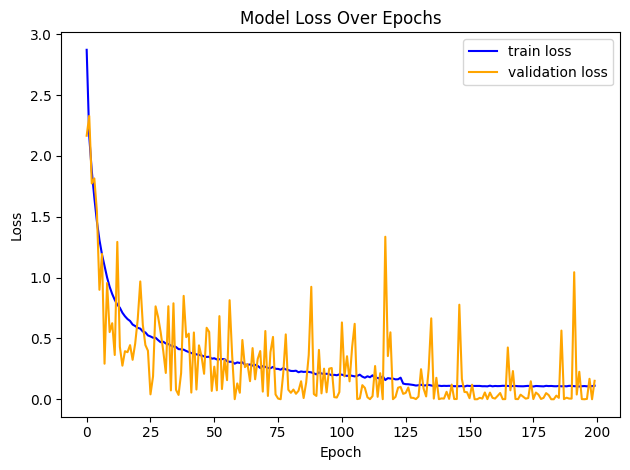

In [ ]:
plt.plot((np.array(train_loss_values)), label="train loss", color='blue')
plt.plot((np.array(validation_loss_values)), label="validation loss", color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

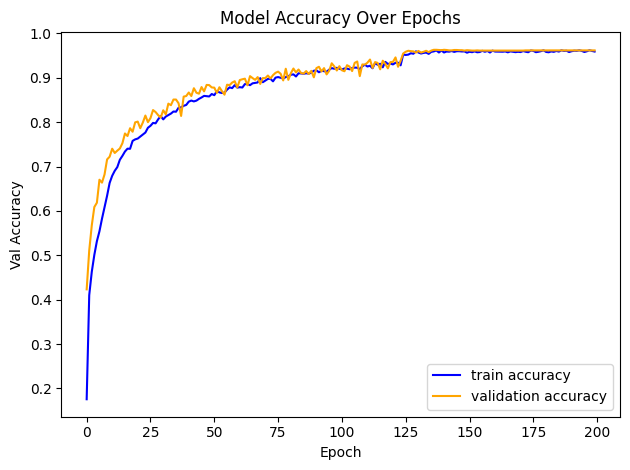

In [ ]:
plt.plot(train_accuracy_values, label='train accuracy', color='blue')
plt.plot(validation_accuracy_values, label='validation accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

# LOAD AND TEST MODEL

In [ ]:
# model = SIBILSTMModel(input_size=5, hidden_size=64, num_layers=3, output_size=26, seq_length=SEQ_LENGTH).to(device)
model = SIBILSTMModel(input_size=5, hidden_size=64, num_layers=2, output_size=26).to(device)
model.load_state_dict(torch.load("/content/models/lstm_flex_best_model.pth"))
model.eval()

y_pred, y_true = [], []
score = 0
for i in range(len(testseq)):
  input_tensor = torch.tensor(testseq[i][0], dtype=torch.float32).unsqueeze(0).to(device)
  out = model(input_tensor)

  pred = chr(torch.argmax(out).item() + 97)
  true = chr(torch.argmax(testseq[i][1]).item() + 97)

  y_pred.append(pred)
  y_true.append(true)

  score += 1 if true==pred else 0

print(f"Test Score = {round(score/len(testseq), 2)}")

Test Score = 0.97


In [ ]:
LETTERS = 'abcdefghijklmnopqrstuvwxyz'

In [ ]:
def draw_confusion_matrix(y_true, y_pred, labels=None, figsize=(15, 15)):
  conf_mat = confusion_matrix(y_true, y_pred, labels = labels)
  conf_mat_norm = np.around(conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  cmp = ConfusionMatrixDisplay(conf_mat_norm, display_labels=labels)

  fig, ax = plt.subplots(figsize=figsize)
  cmp.plot(ax=ax)

In [ ]:
def multilabel_confusion_dataframe(y_true, y_pred, index=None):
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report = df_report.iloc[:-3, :3]

    df_report['error'] = 1 - df_report['f1-score']

    avg_row = df_report.mean()
    df_report.loc['average'] = avg_row

    return df_report

In [ ]:
draw_confusion_matrix(y_true, y_pred, labels=[letter for letter in LETTERS], figsize=(15, 15))

NameError: name 'y_true' is not defined

In [ ]:
multilabel_confusion_dataframe(y_true, y_pred, index=[letter for letter in LETTERS])

,precision,recall,f1-score,error
a,0.988889,1.000000,0.994413,0.005587
b,1.000000,1.000000,1.000000,0.000000
c,0.977273,0.966292,0.971751,0.028249
d,0.967033,0.988764,0.977778,0.022222
e,0.988889,0.978022,0.983425,0.016575
f,1.000000,1.000000,1.000000,0.000000
g,0.945652,0.977528,0.961326,0.038674
h,0.976744,0.943820,0.960000,0.040000
i,0.875000,0.865169,0.870056,0.129944
j,0.866667,0.876404,0.871508,0.128492


# REALTIME RESULT TEST

In [ ]:
# @title <p> Download Real Time Test Result
url = 'https://drive.google.com/file/d/1lUXNX670HmZrt48jWoQjusaPqudaiXS1/view?usp=sharing'
output_path = 'Flex.zip'
gdown.download(url, output_path, quiet=False,fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1lUXNX670HmZrt48jWoQjusaPqudaiXS1
To: /content/Flex.zip
100%|██████████| 47.1k/47.1k [00:00<00:00, 47.3MB/s]


'Flex.zip'

In [ ]:
# @title <p> Assign file path
REALTIME_DIR = 'Flex'

if not os.path.isdir(REALTIME_DIR) :
  !unzip Flex.zip &> /dev/null

In [ ]:
def read_result_zip():
  TEST_PARTICIPANTS = ['steven', 'maul', 'bayu', 'afiq', 'robby', 'ihsan', 'fidel']
  result_dict = {letter: {participant: None for participant in TEST_PARTICIPANTS} for letter in LETTERS}
  result_dir = 'Flex'
  for result_file in os.listdir(result_dir):
    try :
      participant = result_file.split('-')[0]
      letter = result_file.split('-')[1]
      with open(os.path.join(result_dir, result_file), 'r') as f:
        result_data = f.read().splitlines()

      if len(result_data) < 100 :
        print(result_file)
      result_dict[letter][participant] = result_data[:100]

    except :
      continue

  return result_dict

In [ ]:
def result_true_pred(result_dict):
  y_true, y_pred = [], []
  for letter, participant_data in result_dict.items():
    for participant, data in participant_data.items():
      if letter is not None and data is not None :
        y_true = y_true + [letter]*100
        y_pred = y_pred + data

  return y_true, y_pred

In [ ]:
result_dict

{'a': {'steven': ['a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a'],
  'maul': ['a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',
   'a',


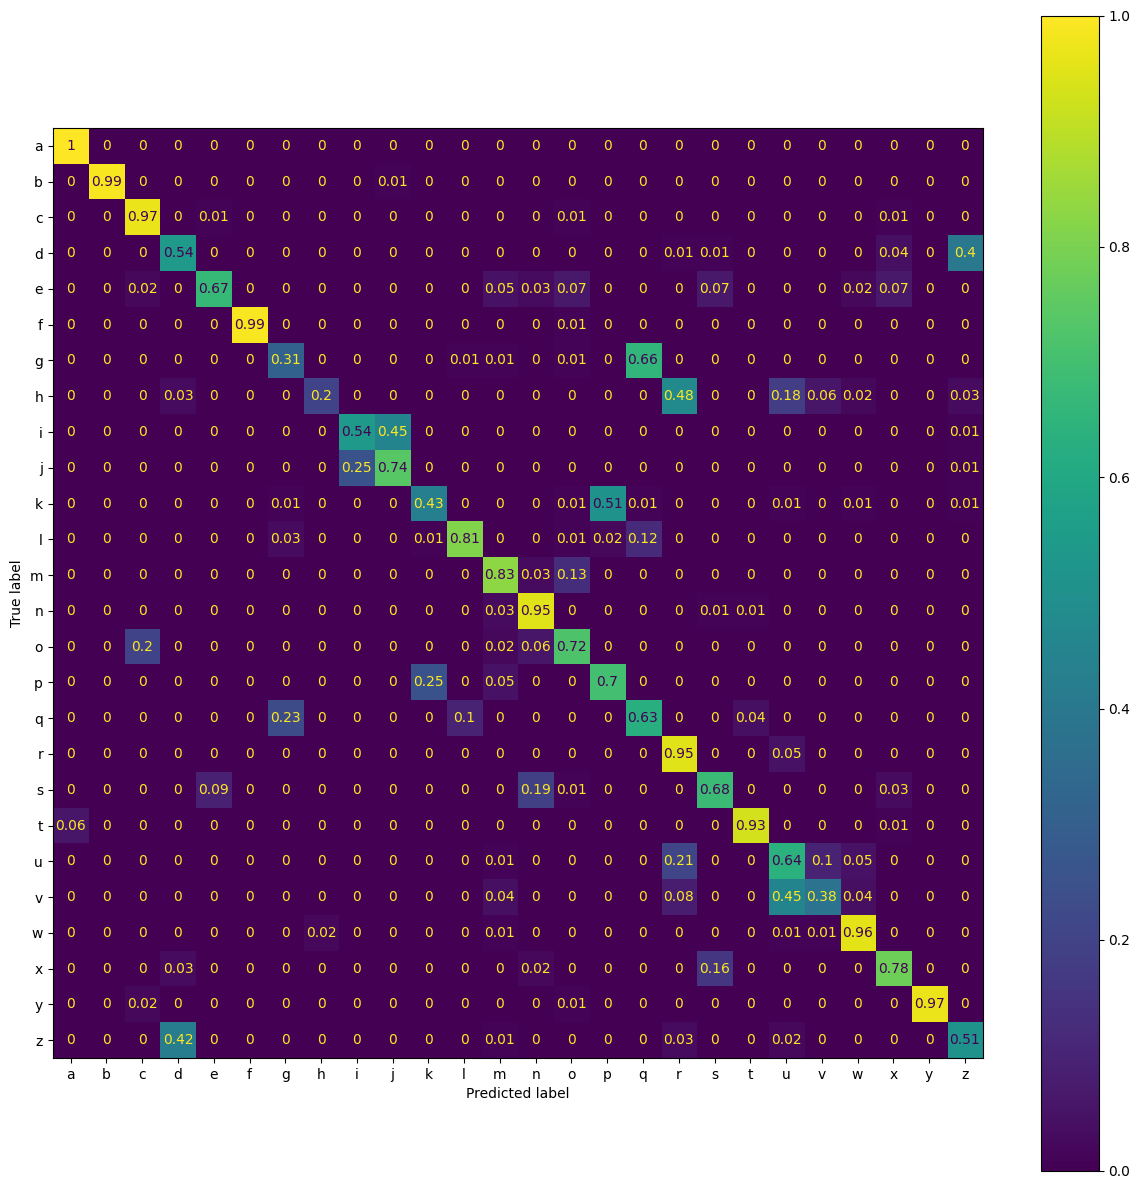

In [ ]:
# @title <p> Draw Confusion Matrix
result_dict = read_result_zip()
y_true_test, y_pred_test = result_true_pred(result_dict)
draw_confusion_matrix(y_true_test, y_pred_test, labels = [letter for letter in LETTERS])

In [ ]:
df_test_score = multilabel_confusion_dataframe(y_true_test, y_pred_test)
df_test_score

,precision,recall,f1-score,error
a,0.942127,1.000000,0.970201,0.029799
b,0.997114,0.987143,0.992103,0.007897
c,0.822464,0.972857,0.891361,0.108639
d,0.527197,0.540000,0.533522,0.466478
e,0.863469,0.668571,0.753623,0.246377
f,1.000000,0.994286,0.997135,0.002865
g,0.534653,0.308571,0.391304,0.608696
h,0.886792,0.201429,0.328289,0.671711
i,0.683544,0.540000,0.603352,0.396648
j,0.617402,0.740000,0.673164,0.326836
